In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import itertools
import logging
import math
import os
import time as tm

import torch
import torch.distributions.constraints as constraints
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import sys

import pyro
from pyro.contrib.easyguide import easy_guide
from pyro.optim import Adam
import pyro.optim
import pyro.infer
import pyro.distributions as dist
import pyro.contrib.autoguide as autoguide
from pyro.infer import SVI, Trace_ELBO

In [3]:
from models import *
from svi_funcs import *
from utils import *

In [4]:
raw_df = pd.read_csv('data_sets/GSE154112_Three-way_ovarian_cancer_gRNA_screen_count_per_million_reads.csv', header=1).fillna(0)

# A NUM_COMBOSx5 matrix of guide indices (first three columns) by
# log fold changes between D15 and D26 for rep1 and rep2
data_df = pd.DataFrame([list(raw_df['Key'].str.split(',', expand=True).T.astype(int).loc[0]),
                        list(raw_df['Key'].str.split(',', expand=True).T.astype(int).loc[1]),
                        list(raw_df['Key'].str.split(',', expand=True).T.astype(int).loc[2]),
                        list(raw_df['Cell_D26_rep1']),
                        list(raw_df['Cell_D15_rep1']),
                        list(raw_df['Cell_D26_rep2']),
                        list(raw_df['Cell_D15_rep2'])]).T

data_df.columns = ['g1', 'g2', 'g3',
                   'Cell_D26_rep1',
                   'Cell_D15_rep1',
                   'Cell_D26_rep2',
                   'Cell_D15_rep2']

lfcs = torch.tensor(np.log2(list((raw_df['Cell_D26_rep1'] + raw_df['Cell_D26_rep2']) / 2.0 + 1.0))
                    - np.log2(list((raw_df['Cell_D15_rep1'] + raw_df['Cell_D15_rep2']) / 2.0 + 1.0)))


In [36]:
scc_pval

0.0

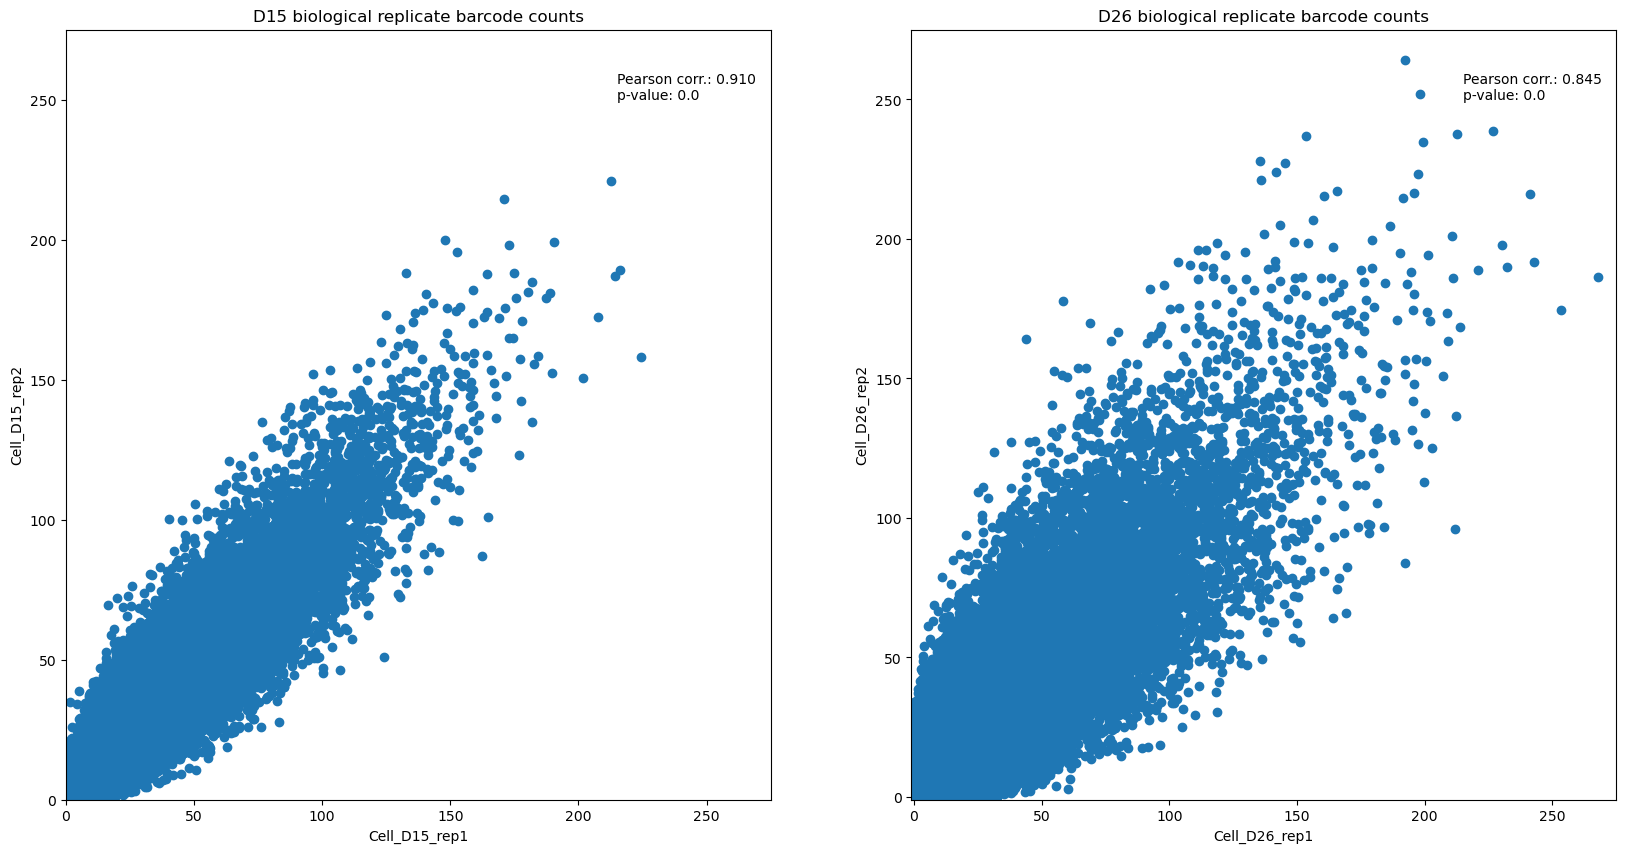

In [48]:
tko_data = pd.read_csv('data_sets/GSE154112_Three-way_ovarian_cancer_gRNA_screen_count_per_million_reads.csv', header=1).fillna(0)
tko_data = tko_data.fillna(-1)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

scc, scc_pval = spearmanr(tko_data[['Cell_D15_rep1']], tko_data[['Cell_D15_rep2']])
pcc, pcc_pval = pearsonr(tko_data[['Cell_D15_rep1']].T.values[0], tko_data[['Cell_D15_rep2']].T.values[0])

ax[0].scatter(x=tko_data[['Cell_D15_rep1']], y=tko_data[['Cell_D15_rep2']])
ax[0].set_title('D15 biological replicate barcode counts')
ax[0].set_xlabel('Cell_D15_rep1')
ax[0].set_ylabel('Cell_D15_rep2')

ax[0].set_xlim(0, 275)
ax[0].set_ylim(0, 275)

ax[0].text(215, 250, f"Pearson corr.: {round(pcc, 3)}0\np-value: {pcc_pval}")

scc, scc_pval = spearmanr(tko_data[['Cell_D26_rep1']], tko_data[['Cell_D26_rep2']])
pcc, pcc_pval = pearsonr(tko_data[['Cell_D26_rep1']].T.values[0], tko_data[['Cell_D26_rep2']].T.values[0])

ax[1].scatter(x=tko_data[['Cell_D26_rep1']], y=tko_data[['Cell_D26_rep2']])
ax[1].set_title('D26 biological replicate barcode counts')
ax[1].set_xlabel('Cell_D26_rep1')
ax[1].set_ylabel('Cell_D26_rep2')

ax[1].text(215, 250, f"Pearson corr.: {round(pcc, 3)}\np-value: {pcc_pval}")

ax[1].set_xlim(-1, 275)
ax[1].set_ylim(-1, 275)

fig.savefig(f"images/preprocessing/raw_barcode_counts.png", dpi=300, bbox_inches='tight')

plt.show()

In [6]:
raw_df = pd.read_csv('data_sets/GSE154112_Three-way_ovarian_cancer_gRNA_screen_count_per_million_reads.csv', header=1).fillna(0)

n_genes = 16
n_guides = 32

# Run some cleanup on in the input data
raw_df[['g1', 'g2', 'g3']] = raw_df['Key'].str.split(',', expand=True).astype(int)  # Expand the 'Key' column from a comma-separated string into its constitute guide index parts
sko_index_mapping_dict = pd.Series((raw_df['mU6 (P3)']).values, index=(raw_df['g1'] - 1)).to_dict()  # Build a map from guide indices to guide names

# Generate log2 fold-changes from D15 to D26 and store as a torch.tensor
lfcs = torch.tensor(np.log2(list((raw_df['Cell_D26_rep1'] + raw_df['Cell_D26_rep2']) / 2.0 + 1.0))
                    - np.log2(list((raw_df['Cell_D15_rep1'] + raw_df['Cell_D15_rep2']) / 2.0 + 1.0)))

# Store guide indices as a torch.tensor
sko_ind_mat = torch.tensor(raw_df['Key'].str.get_dummies(',').T.values).type(torch.FloatTensor)
dko_ind_mat = build_dko_indicator_matrix(16)
tko_ind_mat = build_tko_indicator_matrix(16)

dko_index_mapping_dict = build_dko_index_mapping_dict(sko_index_mapping_dict)
tko_index_mapping_dict = build_tko_index_mapping_dict(sko_index_mapping_dict)

outputs_dict = {}

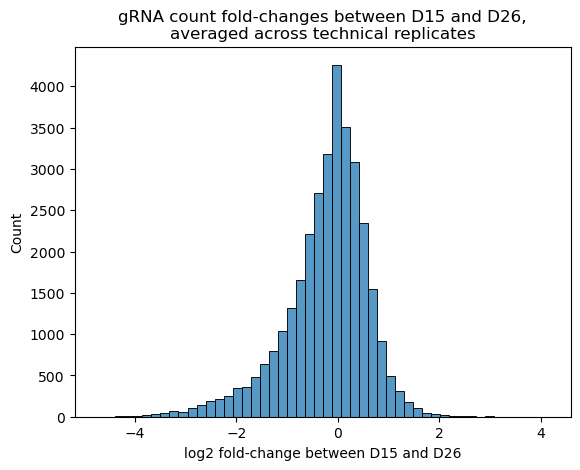

In [50]:
sns.histplot(lfcs, bins=50)
plt.title('gRNA count fold-changes between D15 and D26,\naveraged across technical replicates')
plt.xlabel('log2 fold-change between D15 and D26')

plt.savefig(f"images/preprocessing/lfc_distributions.png", dpi=300)

plt.show()